# **Data Preprocessing**

In [1]:
import pandas as pd

data = pd.read_excel('/content/Grammar Correction.xlsx')

data.head()

,Serial Number,Error Type,Ungrammatical Statement,Standard English
0,1,Verb Tense Errors,I goes to the store everyday.,I go to the store everyday.
1,2,Verb Tense Errors,They was playing soccer last night.,They were playing soccer last night.
2,3,Verb Tense Errors,She have completed her homework.,She has completed her homework.
3,4,Verb Tense Errors,He don't know the answer.,He doesn't know the answer.
4,5,Verb Tense Errors,The sun rise in the east.,The sun rises in the east.


In [2]:
input_sentences = data['Ungrammatical Statement'].tolist()
output_sentences = data['Standard English'].tolist()

In [3]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing the sentences
input_tokens = [tokenizer.encode(sentence, add_special_tokens=True, max_length=128, padding='max_length', truncation=True) for sentence in input_sentences]
output_tokens = [tokenizer.encode(sentence, add_special_tokens=True, max_length=128, padding='max_length', truncation=True) for sentence in output_sentences]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
from sklearn.model_selection import train_test_split

train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(input_tokens, output_tokens, test_size=0.2, random_state=42)
train_inputs, val_inputs, train_outputs, val_outputs = train_test_split(train_inputs, train_outputs, test_size=0.25, random_state=42)

# **Exploratory Data Analysis (EDA):**

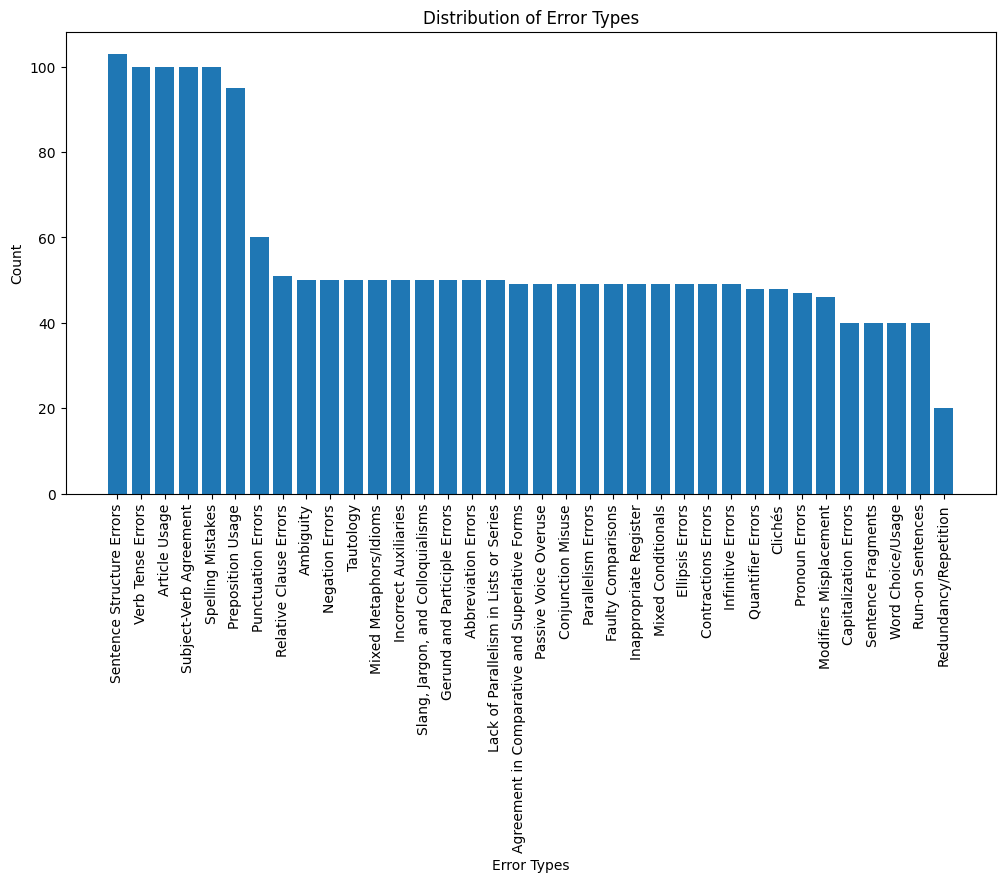

In [5]:
import matplotlib.pyplot as plt

error_counts = data['Error Type'].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(error_counts.index, error_counts.values)
plt.title('Distribution of Error Types')
plt.xlabel('Error Types')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

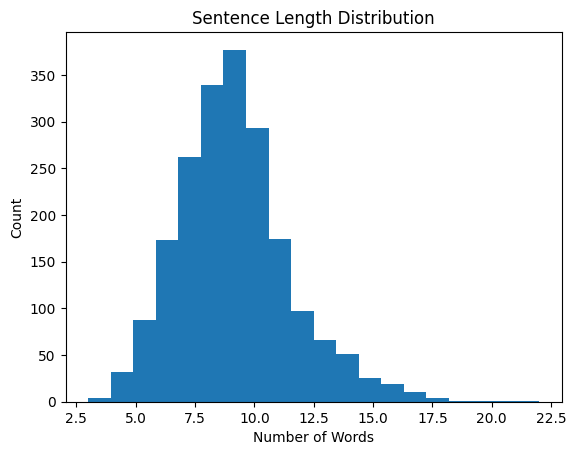

In [6]:
lengths = [len(sent.split()) for sent in data['Ungrammatical Statement']]
plt.hist(lengths, bins=20)
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

# **Baseline Machine Learning Model Bert:**

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(data['Ungrammatical Statement'])

In [8]:
!pip install -q datasets==2.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.8 MB/s eta 0:00:00


In [9]:
from transformers import EncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import Dataset

train_dataset = Dataset.from_dict({'input_ids': train_inputs, 'labels': train_outputs})
val_dataset = Dataset.from_dict({'input_ids': val_inputs, 'labels': val_outputs})

model = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")

model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id

training_args = Seq2SeqTrainingArguments(
    output_dir='./models/',
    evaluation_strategy='epoch',
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True
)
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

Epoch,Training Loss,Validation Loss
1,No log,0.532764
2,No log,0.501658
3,No log,0.449511


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:623: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:643: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


TrainOutput(global_step=228, training_loss=0.9409154256184896, metrics={'train_runtime': 249.5978, 'train_samples_per_second': 14.543, 'train_steps_per_second': 0.913, 'total_flos': 556709596185600.0, 'train_loss': 0.9409154256184896, 'epoch': 3.0})

In [10]:
from nltk.translate.bleu_score import sentence_bleu
from datasets import Dataset
import torch
from transformers import BertTokenizer, EncoderDecoderModel, pipeline
import numpy as np

test_dataset = Dataset.from_dict({'input_ids': test_inputs, 'labels': test_outputs})

model.eval()

generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=0, decoder_start_token_id=tokenizer.cls_token_id)

test_results = test_dataset.map(lambda x: {"predicted": generator(tokenizer.decode(x['input_ids'], skip_special_tokens=True), max_length=128)[0]['generated_text']})

references = [tokenizer.decode(g, skip_special_tokens=True) for g in test_dataset['labels']]
hypotheses = [pred['predicted'] for pred in test_results]

bleu_scores = [sentence_bleu([ref.split()], hyp.split()) for ref, hyp in zip(references, hypotheses)]
average_bleu = np.mean(bleu_scores)
print(f"Average BLEU Score: {average_bleu}")

The model 'EncoderDecoderModel' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalL

  0%|          | 0/404 [00:00<?, ?ex/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Average BLEU Score: 0.31162349529639416


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [11]:
from sklearn.metrics import accuracy_score, f1_score

# Convert predictions to binary labels for the purpose of F1 and accuracy calculation
binary_references = [1 if ref == hyp else 0 for ref, hyp in zip(references, hypotheses)]
binary_hypotheses = [1 if len(hyp.split()) > 0 else 0 for hyp in hypotheses]  # Assume prediction of any text is 'attempt of correction'

# Calculate accuracy and F1 score for binary labels
accuracy = accuracy_score(binary_references, binary_hypotheses)
f1 = f1_score(binary_references, binary_hypotheses)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.019801980198019802
F1 Score: 0.038834951456310676


# **Generative AI Model Fine tuning**

In [12]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, TextDataset, DataCollatorForLanguageModeling

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

data['text'] = data['Ungrammatical Statement'] + " <correct> " + data['Standard English']
dataset = Dataset.from_pandas(data)
dataset = dataset.map(tokenize_function, batched=True)

train_dataset, test_dataset = dataset.train_test_split(test_size=0.1).values()

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?ba/s]

In [13]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

training_args = TrainingArguments(
    output_dir="./models/",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.583487
2,No log,1.530343
3,No log,1.526066


TrainOutput(global_step=342, training_loss=1.4951546652275218, metrics={'train_runtime': 210.6433, 'train_samples_per_second': 25.864, 'train_steps_per_second': 1.624, 'total_flos': 355879747584000.0, 'train_loss': 1.4951546652275218, 'epoch': 3.0})

In [14]:
from transformers import pipeline

generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=0)

text = "She no go to the park every day."

print("Beam Search:")
print(generator(text, max_length=50, num_beams=5, early_stopping=True)[0]['generated_text'])

print("\nSampling:")
print(generator(text, max_length=50, do_sample=True, top_k=50)[0]['generated_text'])

print("\nTemperature Adjusted Sampling:")
print(generator(text, max_length=50, do_sample=True, temperature=0.7)[0]['generated_text'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Beam Search:
She no go to the park every day. <correct> She goes to the park every day. <correct> She goes to the park every day. <correct> She goes to the park every day. <correct> She goes to the park

Sampling:
She no go to the park every day. <correct> She doesn't go to the park every day. <correct> She doesn't go to the park every day.

TABLE OF CONTENTS. <correct> There are no articles in

Temperature Adjusted Sampling:
She no go to the park every day. <correct> She goes to the park every day. <correct> She goes to the park every day. <correct> She goes to the park every day.

TABLE OF CONTENTS. <


In [15]:
print(test_dataset[0])


{'Serial Number': 1012, 'Error Type': 'Conjunction Misuse', 'Ungrammatical Statement': 'She is studying, or she is working on her assignment.', 'Standard English': 'She is either studying or working on her assignment.', 'text': 'She is studying, or she is working on her assignment. <correct> She is either studying or working on her assignment.', 'input_ids': [3347, 318, 11065, 11, 393, 673, 318, 1762, 319, 607, 16237, 13, 1279, 30283, 29, 1375, 318, 2035, 11065, 393, 1762, 319, 607, 16237, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 5025

In [16]:
from nltk.translate.bleu_score import sentence_bleu

output_texts = [generator(tokenizer.decode(inp), max_length=160)[0]['generated_text'] for inp in test_dataset['input_ids']]
references = [tokenizer.decode(out, skip_special_tokens=True) for out in test_dataset['labels']]

bleu_scores = [sentence_bleu([ref.split()], out.split()) for ref, out in zip(references, output_texts)]
average_bleu = sum(bleu_scores) / len(bleu_scores)

print("Average BLEU Score:", average_bleu)

KeyError: "Column labels not in the dataset. Current columns in the dataset: ['Serial Number', 'Error Type', 'Ungrammatical Statement', 'Standard English', 'text', 'input_ids', 'attention_mask']"